# rbfs and depth

Following Eldan and Shamir, let's try and approximate a particular kind of RBF with nets of various depth (and
bounded numbers of hidden units).

First let's think about the details of the RBF to approximate.

In particular, from thm 1:
"Suppose the activation function $\sigma(\cdot)$ satisfies assumption 1 with constant $c_\sigma$, as well as assumption 2. Then there exist universal constants $c, C > 0$ s.t. the following holds: for every dimension $d > C$, there is a probability measure $\mu$ on $\mathbb{R}^d$ and a function $g: \mathbb{R}^d \to \mathbb{R}$ with the following properties:
  1. $g$ is bounded in $[-2, +2]$, supported on $\{x : ||x|| \leq C\sqrt{d}\}$ and expressible by a 3-layer network of width $Cc_\sigma d^{19/4}$.
  2. Every function $f$, expressed by a 2-layer network of width at most $ce^{cd}$, satisfies $\mathbb{E}_{x \sim \mu}(f(x) - g(x))^2 \geq c.$
Noting that by their definition, a 2-layer network is a net with one
hidden layer.


There's a lot of stuff there, especially with all the constants.
The keys seem to be: the function $g$ is bounded and supported on a ball, the three-layer net has width polynomial in the size of the inputs while the two-layer net with exponential parameters can't do it.

We will start by trying to define such a $g$.

A lot of the proof itself seems to result from assuming the probability measure is, for some reason, the Fourier transform of the indicator function for the L2 unit ball. We will try and not do this, because it's a pain.

Unfortunately it seems as though the most common radial basis function, the squared exp, is not included. Intuitively it seems as though it shouldn't be -- the proof does the following:
  1. First two layers compute approximate squared norm
  2. last layer computes a univariate function of the squared norm.
For the eponymous RBF, the univariate function required is exponentiation, which seems as though it is highly likely to require exponential width (hard to imagine how to construct it out of multiplies and adds otherwise).

So what's an RBF-like function without exponentials (and preferably harder guarantees on the support)?

Nothing says we have to be smooth, so let's not.

Still keen to try with some kind of clipped squared-exponential, so let's have a go shall we.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
xs = np.linspace(-2, 2, 1000)
ys = np.exp(-(xs ** 2)/0.25)
ys[np.abs(xs) > 1] = 0

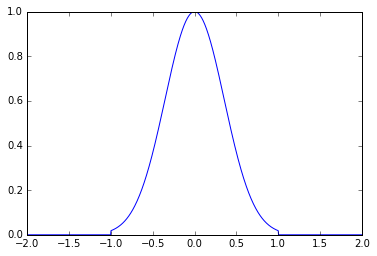

In [3]:
plt.plot(xs, ys)

In [4]:
# or we could do something quadratic
ys = (xs ** 2)  # 1d square norm
ys = 1 - ys
ys[ys < 0] = 0

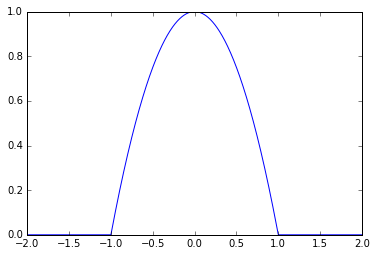

In [5]:
plt.plot(xs, ys)

I rather like this, it seems like it should be ok.
Let's do it in more general arbitrary dimensions and then plot 2.

In [33]:
def c_rbf(data):
    # first make the squared norms
    results = np.sum(data ** 2, axis=1)
    results = 1 - results
    results[results < 0] = 0
    return results

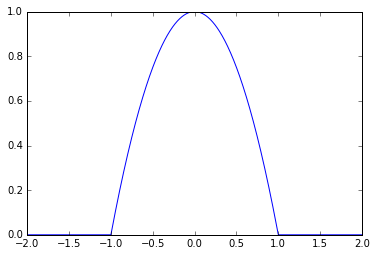

In [34]:
xs = xs.reshape((-1, 1))
ys = c_rbf(xs)
plt.plot(xs, ys)

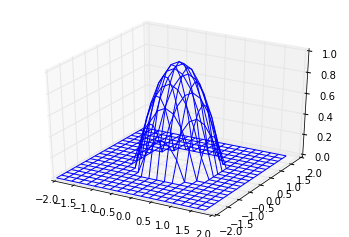

In [35]:
# 3D
from mpl_toolkits.mplot3d import Axes3D

x = y = np.arange(-2.0, 2.0, 0.2)
X, Y = np.meshgrid(x, y)
zs = np.array([c_rbf(np.array([[x,y]])) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z)

In [62]:
# looking good, let's do it in tensorflow
def tf_c_rbf(data):
    results = tf.reduce_sum(data ** 2, reduction_indices=[1])
    results = 1.0 - tf.sin(results)
    return tf.maximum(results, 0.0)


In [63]:
from contextlib import contextmanager

# get a few helpers out of the way

def ff_layer(inputs, size, nonlinearity=tf.nn.relu, scope=None,
             bias=True):
    with tf.variable_scope(scope or 'layer'):
        input_size = inputs.get_shape()[1].value
        weights = tf.get_variable('weights', shape=[input_size, size])
        biases = tf.get_variable('biases', shape=[size])
        
        activations = tf.nn.bias_add(tf.matmul(inputs, weights), biases)
        if nonlinearity is not None:
            activations = nonlinearity(activations)
        return activations

def mse(a, b):
    return tf.reduce_mean(tf.squared_difference(a, b))

# context manager that adds variables to a collection
@contextmanager
def new_collection(name):
    initial_tvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    yield
    new_tvars = [var for var
                 in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
                 if var not in initial_tvars]
    for var in new_tvars:
        tf.add_to_collection(name, var)
        
def train(sess, t_op, loss, steps):
    losses = []
    for step in range(steps):
        b_loss, _ = sess.run([loss, t_op])
        if step % 10 == 0:
            print('\r~~({}) loss: {}'.format(step+1, b_loss), end='')
        losses.append(b_loss)
    return losses

First up, let's make a 3 layer relu net with parameters polynomial in the dimension and train that. If all the layers are square, then
that should be skinny enough. In fact it can be polynomial of degree up to $19/4 = 4.75$, so let's just assume that if a smaller net can do it, that guy can.

In [66]:
tf.reset_default_graph()

input_dims = 1
batch_size = 100
num_epochs = 10000

inputs = tf.random_normal([batch_size, input_dims])
targets = tf_c_rbf(inputs)

with tf.variable_scope('3-layer'):
    with new_collection('3-layer-vars'):
        first = ff_layer(inputs, input_dims*5, scope='1')
        second = ff_layer(first, input_dims*5, scope='2')
        third = ff_layer(second, 1, scope='3', nonlinearity=None, bias=False)
    loss_3 = mse(tf.squeeze(third), targets)
    
    opt_3 = tf.train.GradientDescentOptimizer(0.01)
    train_3 = opt_3.minimize(loss_3, var_list=tf.get_collection('3-layer-vars'))

~~(9991) loss: 0.06331833451986313

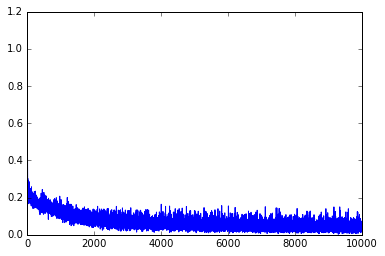

In [67]:
sess = tf.Session()
sess.run(tf.initialize_variables(tf.get_collection('3-layer-vars')))

losses_3 = train(sess, train_3, loss_3, num_epochs)
plt.plot(losses_3)

Let's have a look at the function it's learnt

(10000, 1)


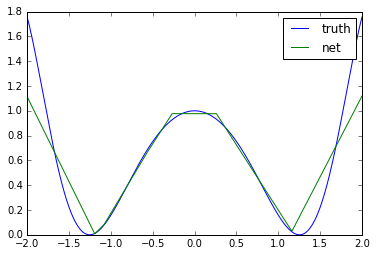

In [68]:
np_x = np.linspace(-2.0, 2.0, batch_size*100).reshape((-1, 1))
print(np_x.shape)

nets, reals = [], []
for i in range(100):
    net_out, real_out = sess.run([third, targets],
                                 {inputs:np_x[i*batch_size:(i+1)*batch_size, :]})
    nets.append(net_out)
    reals.append(real_out)

nets = np.vstack(nets).flatten()
reals = np.vstack(reals).flatten()
plt.plot(np_x, reals, label='truth')
plt.plot(np_x, nets, label='net')
plt.legend()

OK, that kind of gets there. Let's try a wider 2-layer net.

In [69]:
# with tf.variable_scope('2-layer'):
#     with new_collection('2-layer-vars'):
#         first = ff_layer(inputs, int(np.exp(input_dims)), scope='1')
#         second = ff_layer(first, 1, scope='2', nonlinearity=None, bias=False)
#     loss_2 = mse(second, targets)
    
#     opt_2 = tf.train.GradientDescentOptimizer(0.001)
#     train_2 = opt_2.minimize(loss_2, var_list=tf.get_collection('2-layer-vars'))

# sess.run(tf.initialize_variables(tf.get_collection('2-layer-vars')))

# losses_2 = train(sess, train_2, loss_2, num_epochs)
# plt.plot(losses_2)

And a two layer net with polynomial parameters.

~~(9991) loss: 0.0266238022595644

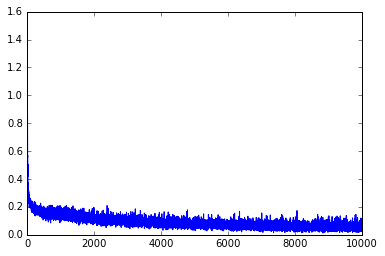

In [70]:
with tf.variable_scope('2-layer-poly'):
    with new_collection('2-layer-poly-vars'):
        first = ff_layer(inputs, input_dims*50, scope='1')
        second = ff_layer(first, 1, scope='2', nonlinearity=None, bias=False)
    loss_2_p = mse(tf.squeeze(second), targets)
    
    opt_2_p = tf.train.GradientDescentOptimizer(0.001)
    train_2_p = opt_2_p.minimize(loss_2_p, var_list=tf.get_collection('2-layer-poly-vars'))

sess.run(tf.initialize_variables(tf.get_collection('2-layer-poly-vars')))

losses_2_p = train(sess, train_2_p, loss_2_p, num_epochs)
plt.plot(losses_2_p)

(10000, 1)


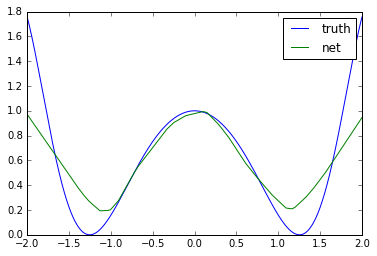

In [71]:
np_x = np.linspace(-2.0, 2.0, batch_size*100).reshape((-1, 1))
print(np_x.shape)

nets, reals = [], []
for i in range(100):
    net_out, real_out = sess.run([second, targets],
                                 {inputs:np_x[i*batch_size:(i+1)*batch_size, :]})
    nets.append(net_out)
    reals.append(real_out)

nets = np.vstack(nets).flatten()
reals = np.vstack(reals).flatten()
plt.plot(np_x, reals, label='truth')
plt.plot(np_x, nets, label='net')
plt.legend()